In [5]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
from matplotlib import pyplot as plt, animation, rc,colors
from datetime import datetime, timedelta
from cartopy import crs, feature
import cmocean
import yaml

from IPython.display import Image
rc('animation', html='html5')

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from OP_functions import *

In [6]:
def get_WW3_path(date):
    """Construct WW3 results path given the date
    e.g., /opp/wwatch3/nowcast/SoG_ww3_fields_YYYYMMDD_YYYYMMDD.nc
    :arg date: date of WW3 record
    :type date: :py:class:`datetime.datetime`
    :returns: WW3 path
    :rtype: str
    """
    # Make WW3 path
    path = '/opp/wwatch3/hindcast'
    datestr = [date.strftime(fmt) for fmt in ('%d%b%y', '%Y%m%d_%Y%m%d')]
    path = os.path.join(path, datestr[0].lower(), f'SoG_ww3_fields_{datestr[1]}.nc')
    if not os.path.exists(path):
        raise ValueError(f"No WW3 record found for the specified date {date.strftime('%Y-%b-%d')}")

    return path

In [7]:
# Define paths
local = 0 #Set to 0 when working on server
paths = path(local)
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])

In [19]:
df=pd.read_csv('/home/jvalenti/MOAD/analysis-jose/OParcels/timeg_2016.csv', index_col=[0])

meantime = df.groupby(by='DeployT').mean()
SD = df.groupby(by='DeployT').sem()
meantime.Timeg = meantime.Timeg/24
SD.Timeg = (SD.Timeg/24)

In [76]:
timedelta(days = 7 ,hours=1)

datetime.timedelta(days=7, seconds=3600)

In [89]:
start = datetime(2015,12,25)
Fraser_week = [0] 
for i in range(0,48):
    Fraser_week.append(0)
    for j in range(168):
        Fraser_week[-1] += float(xr.open_dataset(get_Fraser_path(start+ timedelta(days= i*7,hours=j))).rorunoff[0,500,394].values)*211.8116*3600 #m3/h

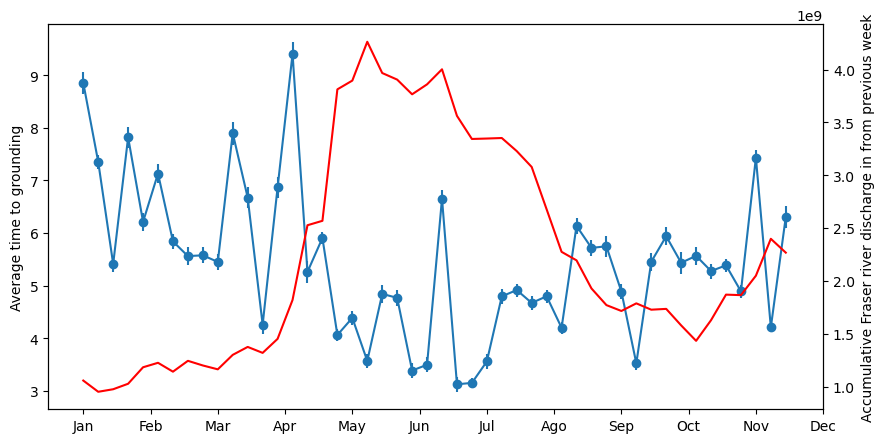

In [93]:
Dept = meantime.index
Groundt = meantime.values
SE = SD.values

se = []
gt = []
for i in range(48):
    se.append(SE[i][0])
    gt.append(Groundt[i][0])

fig,ax = plt.subplots(figsize=(10,5))
ax2 = ax.twinx()
ax.errorbar(Dept,gt,yerr=se,fmt='-o')
plt.xlabel('Time of particle deployment')
ax.set_ylabel('Average time to grounding')
ax2.set_ylabel('Accumulative Fraser river discharge in from previous week')
ax2.plot(Dept,Fraser_week[1:],'r-')

#ax2.set_xticks(np.arange(0,50,4.5), ['Jan', 'Feb', 'Mar','Apr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dec'])
a=ax.set_xticks(np.arange(0,50,4.5), ['Jan', 'Feb', 'Mar','Apr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dec'])

